In [1]:
import os
import argparse
import traceback
import pandas as pd
from collections import defaultdict
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator


# Extraction function
"""
code reference
https://github.com/theRealSuperMario/supermariopy/blob/master/scripts/tflogs2pandas.py
"""
def tflog2pandas(path: str) -> pd.DataFrame:
    """convert single tensorflow log file to pandas DataFrame

    Parameters
    ----------
    path : str
        path to tensorflow log file

    Returns
    -------
    pd.DataFrame
        converted dataframe
    """
    DEFAULT_SIZE_GUIDANCE = {
        "compressedHistograms": 1,
        "images": 1,
        "scalars": 0,  # 0 means load all
        "histograms": 1,
    }
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path, DEFAULT_SIZE_GUIDANCE)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--interest', type=str, required=True)
    parser.add_argument('--save_path', type=str, default='./tb_results')
    parser.add_argument('--tb_path', type=str, default='./tensorboard')
    args = parser.parse_args([])
    return args

if __name__ == '__main__':
    # args = parse_args()
    save_path = './tb_results' # args.save_path
    tb_path = './tensorboard' # args.tb_path
    
    os.makedirs(save_path, exist_ok=True)
    
    interest = 'Median' # args.interest
    
    folders = [os.path.join(tb_path, folder) for folder in os.listdir(tb_path) if interest in folder]
    for folder in folders:
        print(folder)
    metric_keys = ['global_acc', 'global_loss']
    
    metrics_dict = defaultdict(list)
    
    accs_, losses_ = [], []
    for folder in folders:
        file = os.listdir(folder)
        df = tflog2pandas(f'{folder}/{file[0]}')
        for k in metric_keys:
            metrics_dict[k] = df.loc[df['metric']==k]['value']
        df = pd.DataFrame.from_dict(metrics_dict)
        accs_.append(df['global_acc'].to_numpy())
        losses_.append(df['global_loss'].to_numpy())
        # file_name = result = '_'.join(folder.split('_')[2:])    # I use YYYY-MM-DD_HHMMSS_{interest}_{details} for tb event name so...
        # df.to_csv(f"{save_path}/{file_name}.csv")
        # print(f"{save_path}/{file_name}.csv SAVED!")
        
        
    # result_path=save_path
    # desired_stages = ['SITTING', '1', '2', '3', '4', 'all', '#1', '#2', '#3', 'resting']
    # total_files = [os.path.join(result_path, file) for file in os.listdir(result_path) if file.endswith('.csv')]
    # keywords = []
    # files = []
    
    # for stage in desired_stages:
    #     try:
    #         keywords.append('_'.join((interest, stage)))
    #     except:
    #         print(f"NO FILE IN {file}")
    # for file in total_files:
    #     for keyword in keywords:
    #         if keyword in file:
    #             files.append(file)
    
    # final_dict = {stage:{} for stage in desired_stages}
    
    # for file in files:
    #     df = pd.read_csv(file)
    #     stage = file.split('_')[-1].split('.')[0]
    #     for key in metric_keys:
    #         if key == 'Recall':
    #             final_dict[stage]['Sensiticity'] = df[key].to_numpy()[-1]
    #         elif key == 'Test Accuracy':
    #             final_dict[stage][key] = df[key].to_numpy()[-1]/100
    #         else:
    #             final_dict[stage][key] = df[key].to_numpy()[-1]
                
    # final_df = pd.DataFrame.from_dict(final_dict)
    # final_df = final_df[desired_stages]
    # os.makedirs('./result_summaries', exist_ok=True)
    # final_df.to_csv(f'./result_summaries/{interest}.csv')
    # print(f'{interest}.csv SAVED!')

./tensorboard/2024-12-08_06:38:37_Median_MITBIH_GP90|RNN|MITBIH|SGD|0.0005|0.0001|64|0|5|True|100|300|0.5|0.1|NaiveClient|Median|0.2|8.0|1e-05|3.0|GradPrune|LabelFlip|0.25|9|left|0|False|1|0.9
./tensorboard/2024-12-08_06:51:54_Median_MITBIH_GP99|RNN|MITBIH|SGD|0.0005|0.0001|64|0|5|True|100|300|0.5|0.1|NaiveClient|Median|0.2|8.0|1e-05|3.0|GradPrune|LabelFlip|0.25|9|left|0|False|1|0.99
./tensorboard/2024-12-08_05:10:29_Median_MITBIH|RNN|MITBIH|SGD|0.0005|0.0001|64|0|5|True|100|300|0.5|0.1|NaiveClient|Median|0.2|8.0|1e-05|3.0|NoDefense|LabelFlip|0.25|9|left|0|False|1|0.9
./tensorboard/2024-12-08_06:30:44_Median_MITBIH_GP70|RNN|MITBIH|SGD|0.0005|0.0001|64|0|5|True|100|300|0.5|0.1|NaiveClient|Median|0.2|8.0|1e-05|3.0|GradPrune|LabelFlip|0.25|9|left|0|False|1|0.7
./tensorboard/2024-12-07_02:58:13_EISFL|mixer|CIFAR10|SGD|0.001|0.0001|64|0|5|True|100|300|0.5|0.25|NaiveClient|Median|0.2|2.0|0.01|2.0|NoDefense|LabelFlip|0.25|1|left|0|False|1|0.9


RuntimeError: module compiled against API version 0xf but this version of numpy is 0xd

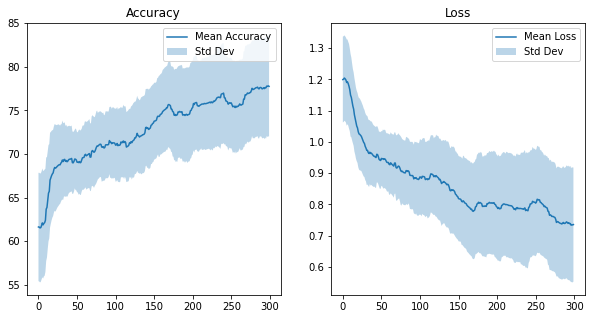

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

accs   = [uniform_filter1d(acc , size=25) for acc in accs_]
losses = [uniform_filter1d(loss, size=25) for loss in losses_]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot accuracy
mean_accs = np.mean(accs, axis=0)
std_accs = np.std(accs, axis=0) / np.sqrt(len(accs))
axes[0].plot(mean_accs, label='Mean Accuracy')
axes[0].fill_between(np.arange(len(mean_accs)), mean_accs - std_accs, mean_accs + std_accs, alpha=0.3, label='Std Dev')
axes[0].set_title("Accuracy")
axes[0].legend()

# Plot loss
mean_losses = np.mean(losses, axis=0)
std_losses = np.std(losses, axis=0) / np.sqrt(len(losses))
axes[1].plot(mean_losses, label='Mean Loss')
axes[1].fill_between(np.arange(len(mean_losses)), mean_losses - std_losses, mean_losses + std_losses, alpha=0.3, label='Std Dev')
axes[1].set_title("Loss")
axes[1].legend()

# Show the plots
plt.show()

1
66.89800033569335
9
62.67800004747179
0


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TypeError: object of type 'numpy.float64' has no len()

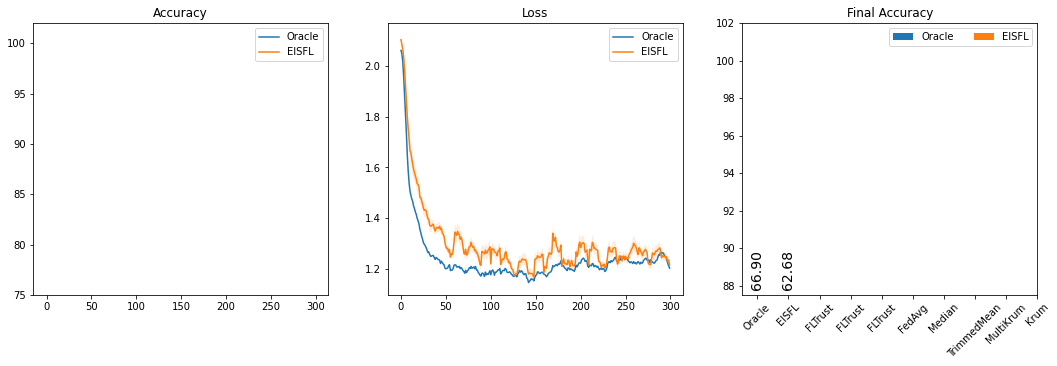

In [12]:
def interests_checker(interests, folder):
    for i in interests:
        if i not in folder:
            return False
    return True
# attack = 'NoiseAdd'
attack = 'LabelFlip'
atk_r  = 0.25
interests = [['Oracle'     , attack, str(atk_r)],
             ['EISFL'      , attack, str(atk_r)],
             ['FLTrust'    , attack, str(atk_r), 'NoDefense'],
             ['FLTrust'    , attack, str(atk_r), 'GradPrune', 'False|1|0.95'],
             ['FLTrust'    , attack, str(atk_r), 'GradPrune', 'False|1|0.99'],
             ['FedAvg'     , attack, str(atk_r)],
             ['Median'     , attack, str(atk_r)],
             ['TrimmedMean', attack, str(atk_r)],
             ['MultiKrum'  , attack, str(atk_r)],
             ['Krum'       , attack, str(atk_r)],]

lower_bound = 87.5
upper_bound = 102
len_cut = 300
gap = 0.25
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, interest in enumerate(interests):
    folders = [os.path.join(tb_path, folder) for folder in os.listdir(tb_path) if interests_checker(interest, folder)]
    print(len(folders))
    # for folder in folders:
    #     print(folder)
    metric_keys = ['global_acc', 'global_loss']
    
    metrics_dict = defaultdict(list)
    
    accs_, losses_ = [], []
    for folder in folders:
        file = os.listdir(folder)
        df = tflog2pandas(f'{folder}/{file[0]}')
        for k in metric_keys:
            metrics_dict[k] = df.loc[df['metric']==k]['value']
        df = pd.DataFrame.from_dict(metrics_dict)
        acc = df['global_acc'].to_numpy()
        loss = df['global_loss'].to_numpy()
        if len(acc) >= len_cut:
            accs_.append(df['global_acc'].to_numpy())
        if len(loss) >= len_cut:
            losses_.append(df['global_loss'].to_numpy())
    accs   = [uniform_filter1d( acc[:len_cut], size=10) for acc in accs_]
    losses = [uniform_filter1d(loss[:len_cut], size=10) for loss in losses_]

    # Create a figure with two subplots
    

    # Plot accuracy
    mean_accs = np.mean(accs, axis=0)
    std_accs = np.std(accs, axis=0) / np.sqrt(len(accs))
    axes[0].plot(mean_accs, label=f'{interest[0]}')
    axes[0].fill_between(np.arange(len(mean_accs)), mean_accs - std_accs, mean_accs + std_accs, alpha=0.15)
    axes[0].set_title("Accuracy")
    axes[0].legend()
    axes[0].set_ylim(75, upper_bound)

    # Plot loss
    mean_losses = np.mean(losses, axis=0)
    std_losses = np.std(losses, axis=0) / np.sqrt(len(losses))
    axes[1].plot(mean_losses, label=f'{interest[0]}')
    axes[1].fill_between(np.arange(len(mean_losses)), mean_losses - std_losses, mean_losses + std_losses, alpha=0.15)
    axes[1].set_title("Loss")
    axes[1].legend()

    # axes[2].scatter([idx], mean_accs[-1], label=f'{interest[0]}', s=100)
    bars = axes[2].bar(idx, mean_accs[-1], yerr=std_accs[-1], label=f'{interest[0]}', capsize=5)
    axes[2].errorbar(idx, mean_accs[-1], yerr=std_accs[-1], fmt='o', color='black')
    axes[2].set_xticks(range(len(interests)))
    axes[2].set_xticklabels([f'{interest[0]}' for interest in interests], rotation=45)
    axes[2].set_title("Final Accuracy")
    axes[2].set_ylim(lower_bound, upper_bound)
    axes[2].legend(ncol=4)

    # Add text on top of each bar
    for i, bar in enumerate(bars):
        height = bar.get_height()
        axes[2].text(
            bar.get_x() + bar.get_width() / 2,  # X position
            lower_bound+gap,                            # Y position (height of the bar)
            f'{mean_accs[-1]:.2f}',         # Text (formatted to 2 decimal places)
            ha='center', va='bottom',           # Horizontal and vertical alignment
            rotation=90,
            fontsize=14
            )
    print(mean_accs[-1])
    # Show the plots
plt.tight_layout()
plt.show()

In [31]:
accs    = [97.88140045166017,
97.15432250976562,
97.57919952392578,
96.53085741315569,
59.626399765014654,
96.0938003540039,
95.07479984283448,
95.29019989013673,
95.51500045776368,
92.96860038757325,]

lpipses = [2.0179757029836765e-06 ,# No Defense
           0.6870802640914917,
           2.0179757029836765e-06 ,# No Defense
           0.5384798049926758     ,# GP 0.9
           0.6867202520370483,
           2.0179757029836765e-06,
           2.0179757029836765e-06,
           2.0179757029836765e-06,
           2.0179757029836765e-06,
           2.0179757029836765e-06]

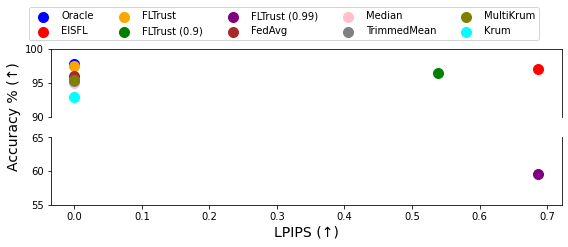

In [84]:
methods = ['Oracle', 'EISFL', 'FLTrust', 'FLTrust (0.9)', 'FLTrust (0.99)', 'FedAvg', 'Median', 'TrimmedMean', 'MultiKrum', 'Krum']
colors = ['blue', 'red', 'orange', 'green', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 3))
for i in range(len(methods)):
    ax1.scatter(lpipses[i], accs[i], s=100, label=methods[i], c=colors[i]) #, c='blue')
    ax1.set_ylim(90, 100)  # 첫 번째 y축 범위 설정
    # ax1.tick_params(labeltop=False)  # 첫 번째 subplot의 상단 라벨 숨기기
    ax1.tick_params(labeltop=False, bottom=False)
ax1.spines['bottom'].set_visible(False)  # 첫 번째 subplot의 하단 경계 숨기기

ax2.scatter(lpipses[4], accs[4], s=100, label=methods[4], c=colors[4]) #, c='blue')
ax2.set_ylim(55, 65)  # 두 번째 y축 범위 설정
ax2.spines['top'].set_visible(False)  # 두 번째 subplot의 상단 경계 숨기기
d = .015  # 축 간격의 길이
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
# ax1.plot((-d, +d), (-d, +d), **kwargs)        # 왼쪽 위
# ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # 오른쪽 위
# ax1.set_xticks(None)
kwargs.update(transform=ax2.transAxes)  # 경계 변환 설정
# ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # 왼쪽 아래
# ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # 오른쪽 아래

# 공통 라벨 설정 및 범례 추가
ax2.set_xlabel('LPIPS (↑)', fontsize=14)
ax1.set_ylabel('Accuracy % (↑)', y=-0., fontsize=14)
# ax2.set_ylabel('Accuracy % (↑)')
fig.legend(methods, ncol=5, bbox_to_anchor=(.5, 1.15), loc='upper center')

plt.tight_layout()
plt.savefig('./figure/lpips_acc.pdf', bbox_inches='tight')
plt.show()

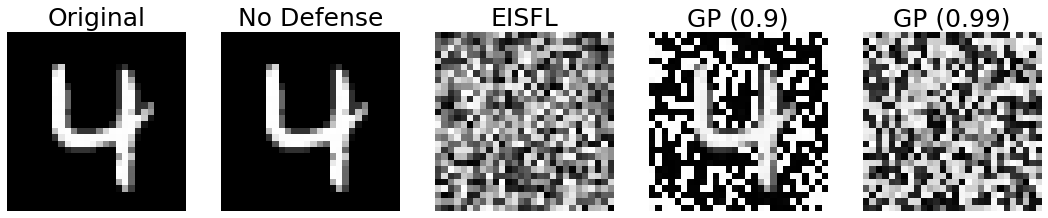

In [92]:
labels = ['Original', 'No Defense', 'EISFL', 'GP (0.9)', 'GP (0.99)']
img_paths = ['./results/NoDefense/IG/49.png',
             './results/NoDefense/IG/49_result.png',
             './results/eisfl/IG/49_result.png',
             './results/GradPrune_0.9/IG/49_result.png',
             './results/GradPrune_0.99/IG/49_result.png',]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = plt.imread(img_paths[i])
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(labels[i], fontsize=25)
plt.tight_layout()
plt.savefig('./attack_examples.pdf', bbox_inches='tight')
plt.show()

['2024-12-08_15:39:41_Oracle_CIFAR10_GP90|mixer|CIFAR10|SGD|0.001|0.0001|64|0|5|True|100|300|0.5|0.1|NaiveClient|Oracle|0.2|8.0|1e-05|3.0|GradPrune|LabelFlip|0.25|9|left|0|False|1|0.9', '2024-12-08_15:38:11_Oracle_CIFAR10_DPL|mixer|CIFAR10|SGD|0.001|0.0001|64|0|5|True|100|300|0.5|0.1|NaiveClient|Oracle|0.2|0.5|1e-05|3.0|DPSGD|LabelFlip|0.25|9|left|0|False|1|0.9', '2024-12-07_06:11:22_EISFL|mixer|CIFAR10|SGD|0.001|0.0001|64|0|5|True|100|300|0.5|0.1|NaiveClient|TrimmedMean|0.2|2.0|0.01|2.0|NoDefense|LabelFlip|0.25|9|left|0|False|1|0.9', '2024-12-08_15:30:55_FedAvg_CIFAR10_GP70|mixer|CIFAR10|SGD|0.001|0.0001|64|0|5|True|100|300|0.5|0.1|NaiveClient|FedAvg|0.2|8.0|1e-05|3.0|GradPrune|LabelFlip|0.25|9|left|0|False|1|0.7', '2024-12-07_08:32:13_DP-S|mixer|CIFAR10|SGD|0.001|0.0001|64|0|5|True|100|300|0.5|0.1|NaiveClient|FedAvg|0.2|8.0|1e-05|3.0|DPSGD|LabelFlip|0.25|9|left|0|False|1|0.9', '2024-12-07_06:11:25_EISFL|mixer|CIFAR10|SGD|0.001|0.0001|64|0|5|True|100|300|0.5|0.1|NaiveClient|Median|0.2

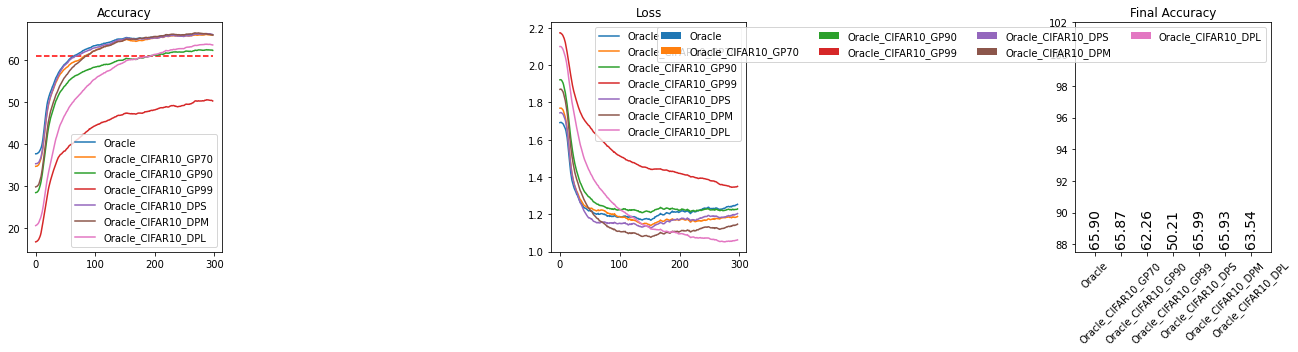

In [35]:
def interests_checker(interests, folder):
    for i in interests:
        if i not in folder:
            return False
    return True
# attack = 'NoiseAdd'
attack = 'LabelFlip'
atk_r  = 0.25
# interests = [['Oracle'     , attack, str(atk_r), 'NoDefense'],
#              ['EISFL'      , attack, str(atk_r), 'NoDefense'],
#              ['FLTrust'    , attack, str(atk_r), 'NoDefense'],
#              ['FLTrust'    , attack, str(atk_r), 'NoDefense', 'False|1|0.95'],
#              ['FLTrust'    , attack, str(atk_r), 'NoDefense', 'False|1|0.99'],
#              ['FedAvg'     , attack, str(atk_r)],
#              ['Median'     , attack, str(atk_r)],
#              ['TrimmedMean', attack, str(atk_r)],
#              ['MultiKrum'  , attack, str(atk_r)],
#              ['Krum'       , attack, str(atk_r)],]
interests = [['Oracle'             , attack, str(atk_r), 'NoDefense'],
            #  ['FedAvg'             , attack, str(atk_r), 'NoDefense'],
            #  ['Median'             , attack, str(atk_r), 'NoDefense'],
            #  ['TrimmedMean'        , attack, str(atk_r), 'NoDefense'],
            #  ['MultiKrum'          , attack, str(atk_r), 'NoDefense'],
            #  ['FLTrust'            , attack, str(atk_r), 'NoDefense'],
            #  ['EISFL_CIFAR10'      , attack, str(atk_r), 'NoDefense'],
            #  ['DP-S'               , attack, str(atk_r), 'DP'],
            #  ['DP-M'               , attack, str(atk_r), 'DP'],
            #  ['DP-L'               , attack, str(atk_r), 'DP'],
            #  ['FedAvg_CIFAR10_GP70', attack, str(atk_r), 'GradPrune'],
            #  ['FedAvg_CIFAR10_GP90', attack, str(atk_r), 'GradPrune'],
            #  ['FedAvg_CIFAR10_GP99', attack, str(atk_r), 'GradPrune'],
             ['Oracle_CIFAR10_GP70', attack, str(atk_r),],
             ['Oracle_CIFAR10_GP90', attack, str(atk_r),],
             ['Oracle_CIFAR10_GP99', attack, str(atk_r),],
             ['Oracle_CIFAR10_DPS' , attack, str(atk_r),],
             ['Oracle_CIFAR10_DPM' , attack, str(atk_r),],
             ['Oracle_CIFAR10_DPL' , attack, str(atk_r),]]


tb_path = './tensorboard_cifar10'
print(os.listdir(tb_path))
lower_bound = 87.5
upper_bound = 102
len_cut = 298
gap = 0.25
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, interest in enumerate(interests):
    folders = [os.path.join(tb_path, folder) for folder in os.listdir(tb_path) if interests_checker(interest, folder)]
    # print(len(folders))
    # for folder in folders:
    #     print(folder)
    metric_keys = ['global_acc', 'global_loss']
    
    metrics_dict = defaultdict(list)
    
    accs_, losses_ = [], []
    for folder in folders:
        file = os.listdir(folder)
        df = tflog2pandas(f'{folder}/{file[0]}')
        for k in metric_keys:
            metrics_dict[k] = df.loc[df['metric']==k]['value']
        df = pd.DataFrame.from_dict(metrics_dict)
        acc = df['global_acc'].to_numpy()
        loss = df['global_loss'].to_numpy()
        if len(acc) >= len_cut:
            accs_.append(df['global_acc'].to_numpy())
        if len(loss) >= len_cut:
            losses_.append(df['global_loss'].to_numpy())
    accs   = [uniform_filter1d( acc[:len_cut], size=int(300*0.1)) for acc in accs_]
    losses = [uniform_filter1d(loss[:len_cut], size=int(300*0.1)) for loss in losses_]

    # Create a figure with two subplots
    

    # Plot accuracy
    mean_accs = np.mean(accs, axis=0)
    std_accs = np.std(accs, axis=0) / np.sqrt(len(accs))
    axes[0].plot(mean_accs, label=f'{interest[0]}')
    axes[0].fill_between(np.arange(len(mean_accs)), mean_accs - std_accs, mean_accs + std_accs, alpha=0.15)
    axes[0].set_title("Accuracy")
    axes[0].legend()
    # axes[0].set_ylim(75, upper_bound)

    # Plot loss
    mean_losses = np.mean(losses, axis=0)
    std_losses = np.std(losses, axis=0) / np.sqrt(len(losses))
    axes[1].plot(mean_losses, label=f'{interest[0]}')
    axes[1].fill_between(np.arange(len(mean_losses)), mean_losses - std_losses, mean_losses + std_losses, alpha=0.15)
    axes[1].set_title("Loss")
    axes[1].legend()

    # axes[2].scatter([idx], mean_accs[-1], label=f'{interest[0]}', s=100)
    bars = axes[2].bar(idx, mean_accs[-1], yerr=std_accs[-1], label=f'{interest[0]}', capsize=5)
    axes[2].errorbar(idx, mean_accs[-1], yerr=std_accs[-1], fmt='o', color='black')
    axes[2].set_xticks(range(len(interests)))
    axes[2].set_xticklabels([f'{interest[0]}' for interest in interests], rotation=45)
    axes[2].set_title("Final Accuracy")
    axes[2].set_ylim(lower_bound, upper_bound)
    axes[2].legend(ncol=4)

    # Add text on top of each bar
    for i, bar in enumerate(bars):
        height = bar.get_height()
        axes[2].text(
            bar.get_x() + bar.get_width() / 2,  # X position
            lower_bound+gap,                            # Y position (height of the bar)
            f'{mean_accs[-1]:.2f}',         # Text (formatted to 2 decimal places)
            ha='center', va='bottom',           # Horizontal and vertical alignment
            rotation=90,
            fontsize=14
            )
    print(interest[0], mean_accs[-1])
    # Show the plots
axes[0].hlines(61, 0, len(mean_losses), colors='r', linestyles='dashed', label='0.5')
plt.tight_layout()
plt.show()

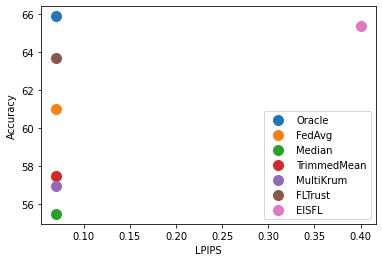

In [28]:
methods = ['Oracle', 'FedAvg', 'Median', 'TrimmedMean', 'MultiKrum', 'FLTrust', 'EISFL']
accs  = [65.90233306884765, 61.03666725158691 ,55.494999440511066 ,57.47733294169108, 56.94200083414714,63.68400077819824, 65.40749028523763]
lpips = [0.07,0.07,0.07,0.07,0.07,0.07,0.40]

for idx, m in enumerate(methods):
    plt.scatter(lpips[idx], accs[idx], s=100, label=m)
plt.xlabel('LPIPS')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
